In [2]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import sys
import pickle
import time

import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertModel
import matplotlib.pyplot as plt

sys.path.append('code')
sys.path.append("/jet/home/azhang19/stat 214/stat-214-lab3-group6/code")

from preprocessing import downsample_word_vectors, make_delayed

torch.set_float32_matmul_precision("high")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the base path for data access
data_path = '/ocean/projects/mth240012p/shared/data' # Path where data files are stored
ckpt_path = '/ocean/projects/mth240012p/azhang19/lab3/ckpts'

In [3]:
# %% Load preprocessed word sequences (likely includes words and their timings)
with open(f'{data_path}/raw_text.pkl', 'rb') as file:
    wordseqs = pickle.load(file) # wordseqs is expected to be a dictionary: {story_id: WordSequenceObject}

# %% Get list of story identifiers and split into training and testing sets
# Assumes story data for 'subject2' exists and filenames are story IDs + '.npy'
stories = [i[:-4] for i in os.listdir(f'{data_path}/subject2')] # Extract story IDs from filenames
# Split stories into train and test sets with a fixed random state for reproducibility


# First, use 60% for training and 40% for the remaining data.
train_stories, temp_stories = train_test_split(stories, train_size=0.6, random_state=214)
# Then split the remaining 40% equally to get 20% validation and 20% test.
val_stories, test_stories = train_test_split(temp_stories, train_size=0.5, random_state=214)

#train, test = train[:10], test[:10] # For testing purposes, limit to first 10 stories in each set

In [4]:
import os
import sys
import pickle

import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing # For StandardScaler
import sklearn.decomposition # For PCA
import matplotlib.pyplot as plt
from staticvectors import StaticVectors # Already imported above

sys.path.append('code')
sys.path.append("/jet/home/azhang19/stat 214/stat-214-lab3-group6/code")

import word_embedding # Imports the classes defined above if they are in word_embedding.py

# Define the base path for data access
data_path = '/ocean/projects/mth240012p/shared/data' # Path where data files are stored

#### 3.1 Models - Word2Vec, GloVe, BoW

In [10]:
class SafeStaticVectorsModel(word_embedding.StaticVectorsModel):
    """
    A safe wrapper around StaticVectorsModel that returns a zero vector
    for tokens not found in the pre-trained vocabulary to avoid negative seed errors.
    """
    def transform(self, text):
        """
        Transforms a list of words into a matrix of word embeddings.
        For unknown words (not in the vocabulary), returns a zero vector.
        
        Args:
            text (list): A list of tokens (words).
        
        Returns:
            np.ndarray: A 2D array with one row per token.
        """
        embeddings_list = []
        # Loop over tokens in the text
        for token in text:
            # Check if token exists in the pre-trained model's tokens dictionary
            if token in self.model.tokens:
                # Retrieve the embedding; self.model.embeddings() returns an array of shape (1, dim)
                emb = self.model.embeddings([token])
                embeddings_list.append(emb[0])
            else:
                # If token is unknown, return a zero vector (avoid calling generate() which can yield a negative seed)
                dim = self.model.config["dim"]
                embeddings_list.append(np.zeros(dim))
        return np.array(embeddings_list)

In [11]:
# Bag of Words
# 1. Fit a Bag-of-Words model on training stories.
bow_model = word_embedding.BagofWords().fit(
    [wordseqs[story].data for story in train_stories]
)

# 2. Create an aggregator to downsample, apply delays (TRs 1-4), standardize, and trim the first 5 and last 10 timepoints.
bow_aggregator = word_embedding.embeddings_aggregator(
    delays=range(1, 5),
    standardize=True,
    trim_range=(5, -10)
)

# 3. Generate downsampled BoW embeddings for all stories (train + validation + test).
all_stories = train_stories + val_stories + test_stories
bow_embedding = word_embedding.embed_sentences(all_stories, wordseqs, bow_model)

# 4. Aggregate features for each split.
X_train_bow = bow_aggregator.fit_transform(train_stories, bow_embedding)
X_val_bow   = bow_aggregator.transform(val_stories, bow_embedding)
X_test_bow  = bow_aggregator.transform(test_stories, bow_embedding)

print("BoW feature shapes:")
print("  X_train_bow:", X_train_bow.shape)
print("  X_val_bow:", X_val_bow.shape)
print("  X_test_bow:", X_test_bow.shape)

BoW feature shapes:
  X_train_bow: (20263, 19540)
  X_val_bow: (7064, 19540)
  X_test_bow: (7459, 19540)


In [12]:
# %% Word2Vec Feature Engineering Pipeline

# 1. Load pre-trained Word2Vec model
w2v_model_path = 'neuml/word2vec' # Path to Word2Vec model
w2v_model = SafeStaticVectorsModel(w2v_model_path)
w2v_aggregator = word_embedding.embeddings_aggregator(
    delays=range(1, 5),
    standardize=True,
    trim_range=(5, -10)
)
w2v_embedding = word_embedding.embed_sentences(all_stories, wordseqs, w2v_model)
X_train_w2v = w2v_aggregator.fit_transform(train_stories, w2v_embedding)
X_val_w2v   = w2v_aggregator.transform(val_stories, w2v_embedding)
X_test_w2v  = w2v_aggregator.transform(test_stories, w2v_embedding)

print("Word2Vec feature shapes:")
print("  X_train_w2v:", X_train_w2v.shape)
print("  X_val_w2v:", X_val_w2v.shape)
print("  X_test_w2v:", X_test_w2v.shape)

Word2Vec feature shapes:
  X_train_w2v: (20263, 1200)
  X_val_w2v: (7064, 1200)
  X_test_w2v: (7459, 1200)


In [13]:
#GloVe

# 1. Load pre-trained GloVe model
glove_model_path = 'neuml/glove-6B' # Path to GloVe model
glove_model = SafeStaticVectorsModel(glove_model_path)
glove_aggregator = word_embedding.embeddings_aggregator(
    delays=range(1, 5),
    standardize=True,
    trim_range=(5, -10)
)
glove_embedding = word_embedding.embed_sentences(all_stories, wordseqs, glove_model)
X_train_glove = glove_aggregator.fit_transform(train_stories, glove_embedding)
X_val_glove   = glove_aggregator.transform(val_stories, glove_embedding)
X_test_glove  = glove_aggregator.transform(test_stories, glove_embedding)

print("GloVe feature shapes:")
print("  X_train_glove:", X_train_glove.shape)
print("  X_val_glove:", X_val_glove.shape)
print("  X_test_glove:", X_test_glove.shape)

GloVe feature shapes:
  X_train_glove: (20263, 1200)
  X_val_glove: (7064, 1200)
  X_test_glove: (7459, 1200)


In [14]:
# %% Define a function to load fMRI data for specified stories and subjects
def load_fmri_data(stories, data_path):
    """
    Loads fMRI data (.npy files) for given stories and subjects.

    Args:
        stories (list): List of story identifiers to load fMRI data for.
        data_path (str): Base path where subject fMRI data is stored (e.g., data_path/subject_id/story_id.npy).

    Returns:
        dict: A nested dictionary `{subject_id: {story_id: fmri_data_array}}`.
    """
    subjects = ['subject2', 'subject3'] # List of subjects to load data for
    fmri_data = {} # Outer dictionary {subject: {story: data}}
    for subject in subjects:
        subject_dict = {} # Inner dictionary {story: data} for the current subject
        for story in stories:
            # Construct the full path to the fMRI data file
            file_path = os.path.join(data_path, subject, f'{story}.npy')
            # Load the NumPy array from the file
            data = np.load(file_path)
            subject_dict[story] = data # Store data in the inner dictionary
        fmri_data[subject] = subject_dict # Store the subject's data dictionary
    return fmri_data

In [15]:
fmri_data = load_fmri_data(all_stories, data_path)

In [16]:
def get_fmri_data(stories, fmri_data):
    """
    Concatenates fMRI data across specified stories for each subject.
    Returns a dictionary: {subject: concatenated_fmri_array}.
    """
    out_dict = {}
    for subj in fmri_data.keys():
        concatenated = np.concatenate(
            [fmri_data[subj][st] for st in stories], axis=0
        )
        out_dict[subj] = concatenated
    return out_dict

# Get concatenated fMRI responses per subject for each split.
fmri_train = get_fmri_data(train_stories, fmri_data)
fmri_val   = get_fmri_data(val_stories, fmri_data)
fmri_test  = get_fmri_data(test_stories, fmri_data)

def pad_nan_to_mean(data):
    """Replace NaN values in a NumPy array with the overall mean of the non-NaN values."""
    mean_val = np.nanmean(data)
    return np.nan_to_num(data, nan=mean_val)

# Apply NaN padding to fMRI data for each subject and split.
for subj in fmri_train:
    fmri_train[subj] = pad_nan_to_mean(fmri_train[subj])
for subj in fmri_val:
    fmri_val[subj] = pad_nan_to_mean(fmri_val[subj])
for subj in fmri_test:
    fmri_test[subj] = pad_nan_to_mean(fmri_test[subj])

# For modeling, we select one subject's data (e.g., subject2)
Y_train = fmri_train['subject2']  # fMRI responses for training
Y_val   = fmri_val['subject2']    # validation responses
Y_test  = fmri_test['subject2']   # test responses

print("fMRI Data Shapes for subject2:")
print("  Y_train:", Y_train.shape)
print("  Y_val:", Y_val.shape)
print("  Y_test:", Y_test.shape)

# Other subject for more analysis
Y_train_3 = fmri_train['subject3']  # fMRI responses for training
Y_val_3   = fmri_val['subject3']    # validation responses
Y_test_3  = fmri_test['subject3']   # test responses

print("fMRI Data Shapes for subject3:")
print("  Y_train:", Y_train_3.shape)
print("  Y_val:", Y_val_3.shape)
print("  Y_test:", Y_test_3.shape)

fMRI Data Shapes for subject2:
  Y_train: (20263, 94251)
  Y_val: (7064, 94251)
  Y_test: (7459, 94251)
fMRI Data Shapes for subject3:
  Y_train: (20263, 95556)
  Y_val: (7064, 95556)
  Y_test: (7459, 95556)


In [17]:
import numpy as np
from scipy.stats import pearsonr

def voxel_correlation(y_true, y_pred):
    """
    Computes voxel-wise Pearson correlation coefficients.
    
    Args:
        y_true (np.ndarray): True fMRI responses (the dim is [n_timepoints, n_voxels])
        y_pred (np.ndarray): Predicted fMRI responses
        
    Return:
        np.ndarray: 1D array with the correlation coefficient for each voxel.
    """
    n_voxels = y_true.shape[1]
    cc = np.zeros(n_voxels)
    for v in range(n_voxels):
        #avoid division by 0
        if np.std(y_true[:, v]) < 1e-6 or np.std(y_pred[:, v]) < 1e-6:
            cc[v] = 0
        else:
            cc[v] = pearsonr(y_true[:, v], y_pred[:, v])[0]
    return cc

all_embeddings = {
    'Word2Vec': {'X_train': X_train_w2v, 'X_val': X_val_w2v, 'X_test': X_test_w2v},
    'GloVe': {'X_train': X_train_glove, 'X_val': X_val_glove, 'X_test': X_test_glove},
    'BoW': {'X_train': X_train_bow, 'X_val': X_val_bow, 'X_test': X_test_bow},
}


#### 3.2 Model - Encoder Embeddings

In [18]:
ckpt_path = '/ocean/projects/mth240012p/chidamba/ckpts/'

dim = 32 # [32, 64]
mlm_prob = 0.15 # [0.1, 0.15, 0.2]
epochs = 1000 # [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
filename = f"dim{dim}_mlm{mlm_prob}_epoch{epochs}.pth"
model, record = torch.load(f"{ckpt_path}/{filename}", weights_only=False, map_location=device)
model = model.to(device).eval()

trim_range = (5, -10)
delays = True
delay_range = [0, 1, 2] # Includes 0, 1, 2

In [19]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
embeddings = {}

for story in stories:
    words = wordseqs[story].data
    tokens = tokenizer(words, add_special_tokens=False, truncation=False,max_length=sys.maxsize)['input_ids']
    token_tensor = torch.tensor(sum(tokens, []), device=device).unsqueeze(0)
    token_per_word = [len(i) for i in tokens]
    with torch.inference_mode():
        output = model(token_tensor,
                    attn_mask=torch.ones_like(token_tensor, device=device, dtype=torch.bool), classification=False)
        output = output.squeeze(0)
    start = 0
    word_embeddings = []
    for i in token_per_word:
        end = start + i
        if i != 0:
            word_embedding = output[start:end].mean(dim=0)
        else:
            word_embedding = torch.zeros(output.size(1), device=device)

        word_embeddings.append(word_embedding)
        start = end
    embeddings[story] = torch.stack(word_embeddings).cpu().numpy()
    
story_embeddings = downsample_word_vectors(stories, embeddings, wordseqs)

for story in stories:
    if delays:
        story_embeddings[story] = make_delayed(story_embeddings[story], delay_range)
    story_embeddings[story] = story_embeddings[story][trim_range[0]:trim_range[1]]

In [20]:
def aggregate_embeddings(story_embeddings, stories):
    """
    Aggregate the embeddings of the stories into a single tensor.
    """
    all_embeddings = []
    for story in stories:
        all_embeddings.append(story_embeddings[story])
    return np.concatenate(all_embeddings, axis=0)

X_train_encoder = aggregate_embeddings(story_embeddings, train_stories)
X_val_encoder = aggregate_embeddings(story_embeddings, val_stories)
X_test_encoder = aggregate_embeddings(story_embeddings, test_stories)

all_embeddings['Encoder'] = {'X_train': X_train_encoder, 'X_val': X_val_encoder, 'X_test': X_test_encoder}

In [21]:
all_embeddings.keys()

dict_keys(['Word2Vec', 'GloVe', 'BoW', 'Encoder'])

#### 3.3 Models - Finetuned and Pretrained BERT

In [29]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import sys
import pickle
import time
import random
import copy
import itertools

import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertModel
from peft import LoraConfig, get_peft_model, TaskType
import matplotlib.pyplot as plt

sys.path.append('code')
sys.path.append("/jet/home/azhang19/stat 214/stat-214-lab3-group6/code")

from BERT.data import TextDataset
from finetune_bert_utils import get_sliding_window_embeddings, aggregate_embeddings, downsample_word_vectors_torch, load_fmri_data, get_fmri_data

torch.set_float32_matmul_precision("high")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the base path for data access
data_path = '/ocean/projects/mth240012p/shared/data'

In [30]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
base_model = BertModel.from_pretrained(model_name)

In [31]:
train_text = [" ".join(wordseqs[i].data).strip() for i in train_stories]
train_dataset = TextDataset(train_text, tokenizer, max_len=sys.maxsize)

In [32]:
trim_range = (5, -10)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
embeddings = {}

texts = []

for story in stories:
    words = wordseqs[story].data
    texts.append(" ".join(words).strip())
    tokens = tokenizer(words, add_special_tokens=False, truncation=False, max_length=sys.maxsize)['input_ids']
    token_per_word = [len(i) for i in tokens]
tokenlized_stories = tokenizer(texts, add_special_tokens=False, padding="longest", truncation=False, max_length=sys.maxsize,
                               return_token_type_ids=False, return_tensors="pt")
input_ids = tokenlized_stories["input_ids"].to(device)
attention_mask = tokenlized_stories["attention_mask"].to(device)

In [33]:
def forward_pass(current_stories, base_model):
    idx = [story_name_to_idx[story] for story in current_stories]
    embeddings = get_sliding_window_embeddings(base_model, input_ids[idx], attention_mask[idx])

    features = {}
    for i, story in enumerate(current_stories):
        words = wordseqs[story].data
        tokens = tokenizer(words, add_special_tokens=False, truncation=False, max_length=sys.maxsize)['input_ids']
        token_per_word = [len(i) for i in tokens]
        story_embeddings = embeddings[i]
        word_embeddings = []
        start = 0
        for i in token_per_word:
            end = start + i
            if i != 0:
                word_embedding = story_embeddings[start:end].mean(dim=0)
            else:
                word_embedding = torch.zeros(story_embeddings.size(1), device=device)
            word_embeddings.append(word_embedding)
            start = end
        
        features[story] = torch.stack(word_embeddings)#.cpu().numpy()

    features = downsample_word_vectors_torch(current_stories, features, wordseqs)
    for story in current_stories:
        features[story] = features[story][trim_range[0]:trim_range[1]]

    aggregated_features = aggregate_embeddings(features, current_stories)
    return aggregated_features

In [34]:
weight_decay = 1e-2

lora_model = True
lora_rank = 8

if lora_model:
    config = LoraConfig(
    r=lora_rank,
    lora_alpha=lora_rank * 2,
    target_modules=['query', 'value'],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION
    )
    
    ckpt = torch.load(f'/jet/home/azhang19/stat 214/stat-214-lab3-group6/code/classifier_ckpt/best_lora_wd{weight_decay}_r{lora_rank}.pth', weights_only=False)
    classifiers = {i: ckpt[i]['classifier_module'] for i in ckpt.keys()}
    lora_weights = {i: ckpt[i]['lora_state_dict'] for i in ckpt.keys()}
else:
    classifiers = torch.load(f'/ocean/projects/mth240012p/azhang19/lab3/classifier_ckpts/best_classifiers{weight_decay}.pth', weights_only=False)

In [35]:
story_name_to_idx = {story: i for i, story in enumerate(stories)}

with torch.inference_mode():
    base_pred_fmri = {}
    lora_pred_fmri = {}
    true_fmri = {}
    for subj in fmri_data.keys():
        base_model = BertModel.from_pretrained(model_name).to(device).eval()
        if lora_model:
            lora_model = get_peft_model(copy.deepcopy(base_model), config).to(device)
            lora_model.load_state_dict(lora_weights[subj])
            lora_model.eval()

        base_features = forward_pass(test_stories, base_model)
        lora_features = forward_pass(test_stories, lora_model)
        
        base_pred_fmri[subj] = classifiers[subj](base_features)
        lora_pred_fmri[subj] = classifiers[subj](lora_features)
        
    print(base_pred_fmri['subject2'].shape)
    print(base_pred_fmri['subject3'].shape)
    print(lora_pred_fmri['subject2'].shape)
    print(lora_pred_fmri['subject3'].shape)
    print(Y_test.shape)
    print(Y_test_3.shape)
    


torch.Size([7459, 94251])
torch.Size([7459, 95556])
torch.Size([7459, 94251])
torch.Size([7459, 95556])
(7459, 94251)
(7459, 95556)


## Model Comparisons

#### Pre-trained vs Fine-tuned BERT Comparison

In [36]:
pretrained_cc_test_subj2 = voxel_correlation(Y_test, base_pred_fmri['subject2'].cpu().numpy())
pretrained_cc_test_subj3 = voxel_correlation(Y_test, base_pred_fmri['subject3'].cpu().numpy())

finetuned_cc_test_subj2 = voxel_correlation(Y_test, lora_pred_fmri['subject2'].cpu().numpy())
finetuned_cc_test_subj3 = voxel_correlation(Y_test, lora_pred_fmri['subject3'].cpu().numpy())

In [37]:
def summarize_cc(cc):
    return {
        'Mean CC':      np.mean(cc),
        'Median CC':    np.median(cc),
        'Top 1% CC':    np.percentile(cc, 99),
        'Top 5% CC':    np.percentile(cc, 95),
    }

In [38]:
import pandas as pd

df_subj2 = pd.DataFrame([
    summarize_cc(pretrained_cc_test_subj2),
    summarize_cc(finetuned_cc_test_subj2),
], index=['Pretrained','Finetuned'])

df_subj3 = pd.DataFrame([
    summarize_cc(pretrained_cc_test_subj3),
    summarize_cc(finetuned_cc_test_subj3),
], index=['Pretrained','Finetuned'])

In [39]:
print("Subject 2 results:\n", df_subj2, "\n")
print("Subject 3 results:\n", df_subj3)

Subject 2 results:
              Mean CC  Median CC  Top 1% CC  Top 5% CC
Pretrained  0.018732   0.014398   0.103731   0.064962
Finetuned   0.020627   0.015985   0.108326   0.069247 

Subject 3 results:
              Mean CC  Median CC  Top 1% CC  Top 5% CC
Pretrained  0.005317   0.005367   0.044171   0.030436
Finetuned   0.005947   0.005888   0.045137   0.031242


In [40]:
print("Subject 2 results:")
df_subj2

Subject 2 results:


,Mean CC,Median CC,Top 1% CC,Top 5% CC
Pretrained,0.018732,0.014398,0.103731,0.064962
Finetuned,0.020627,0.015985,0.108326,0.069247


In [41]:
print("Subject 3 results:")
df_subj3

Subject 3 results:


,Mean CC,Median CC,Top 1% CC,Top 5% CC
Pretrained,0.005317,0.005367,0.044171,0.030436
Finetuned,0.005947,0.005888,0.045137,0.031242


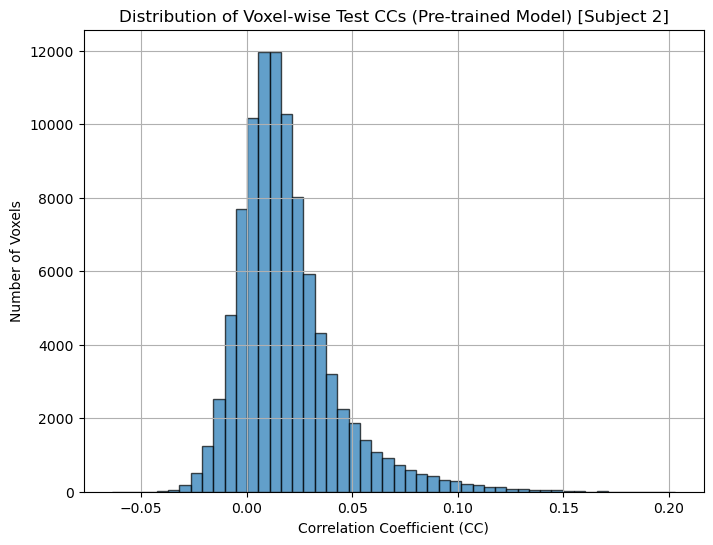

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(pretrained_cc_test_subj2, bins=50, edgecolor='black', alpha=0.7)
plt.title("Distribution of Voxel-wise Test CCs (Pre-trained Model) [Subject 2]")
plt.xlabel("Correlation Coefficient (CC)")
plt.ylabel("Number of Voxels")
plt.grid(True)
plt.savefig('cc_dist_pretrained_subj2', dpi=400)
plt.show()

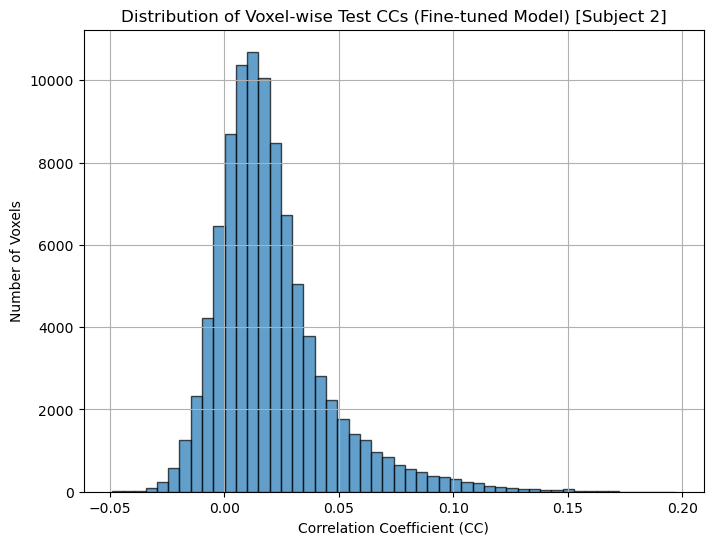

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(finetuned_cc_test_subj2, bins=50, edgecolor='black', alpha=0.7)
plt.title("Distribution of Voxel-wise Test CCs (Fine-tuned Model) [Subject 2]")
plt.xlabel("Correlation Coefficient (CC)")
plt.ylabel("Number of Voxels")
plt.grid(True)
plt.savefig('cc_dist_finetuned_subj2', dpi=400)
plt.show()

#### Comparison with Models from 3.2 and 3.1

In [51]:
subjects = ["subject2", "subject3"]
alpha_best = 1000
cc_store = {
    "subject2": {
        "Finetuned" : finetuned_cc_test_subj2,
        "Pretrained": pretrained_cc_test_subj2,
    },
    "subject3": {
        "Finetuned" : finetuned_cc_test_subj3,
        "Pretrained": pretrained_cc_test_subj3,
    },
}

summary_store = {s: [] for s in cc_store}

for subj, d in cc_store.items():
    for mdl, cc in d.items():
        summary_store[subj].append({"Model": mdl, **summarize_cc(cc)})

In [52]:
encoder_embeddings = {}
encoder_embeddings['Encoder'] = {'X_train': X_train_encoder, 'X_val': X_val_encoder, 'X_test': X_test_encoder}

In [53]:
from sklearn.linear_model import Ridge

#usually use all_embeddings, modified to retrieve a quick result for time efficiency
#for name, embed in all_embeddings.items():
for name, embed in encoder_embeddings.items():
    print(name)
    model = Ridge(alpha=alpha_best)
    model.fit(embed["X_train"], Y_train)
    pred2 = model.predict(embed["X_test"])
    cc2 = voxel_correlation(Y_test, pred2)

    model.fit(embed["X_train"], Y_train_3)
    pred3 = model.predict(embed["X_test"])
    cc3 = voxel_correlation(Y_test_3, pred3)

    cc_store["subject2"][name] = cc2
    cc_store["subject3"][name] = cc3

    summary_store["subject2"].append({"Model": name, **summarize_cc(cc2)})
    summary_store["subject3"].append({"Model": name, **summarize_cc(cc3)})

Encoder


In [54]:
summary_store

{'subject2': [{'Model': 'Finetuned',
   'Mean CC': 0.02062704096307738,
   'Median CC': 0.015984748522798874,
   'Top 1% CC': 0.10832639091642954,
   'Top 5% CC': 0.06924672183883668},
  {'Model': 'Pretrained',
   'Mean CC': 0.018732105487638526,
   'Median CC': 0.01439837070498022,
   'Top 1% CC': 0.10373117966987755,
   'Top 5% CC': 0.06496225343931064},
  {'Model': 'Encoder',
   'Mean CC': 0.005988515286384465,
   'Median CC': 0.005273706756131932,
   'Top 1% CC': 0.04160232157436844,
   'Top 5% CC': 0.029037815551814984}],
 'subject3': [{'Model': 'Finetuned',
   'Mean CC': 0.005947456638594541,
   'Median CC': 0.0058880057524962936,
   'Top 1% CC': 0.04513731620034282,
   'Top 5% CC': 0.031242214350195585},
  {'Model': 'Pretrained',
   'Mean CC': 0.005317009453208727,
   'Median CC': 0.0053674351316797715,
   'Top 1% CC': 0.044170666950518044,
   'Top 5% CC': 0.030435528976579522},
  {'Model': 'Encoder',
   'Mean CC': 0.011400103496434263,
   'Median CC': 0.009270000662305829,
   '

Note: below cell is old output (before pretrained model and encoder fix)

In [99]:
summary_store

{'subject2': [{'Model': 'Finetuned',
   'Mean CC': 0.02062704096307738,
   'Median CC': 0.015984748522798874,
   'Top 1% CC': 0.10832639091642954,
   'Top 5% CC': 0.06924672183883668},
  {'Model': 'Pretrained',
   'Mean CC': 0.02062704096307738,
   'Median CC': 0.015984748522798874,
   'Top 1% CC': 0.10832639091642954,
   'Top 5% CC': 0.06924672183883668},
  {'Model': 'Word2Vec',
   'Mean CC': 0.005647540336684472,
   'Median CC': 0.0044655700350996076,
   'Top 1% CC': 0.05011628043316603,
   'Top 5% CC': 0.03215013061992268},
  {'Model': 'GloVe',
   'Mean CC': 0.0049510441086168646,
   'Median CC': 0.004252985127737622,
   'Top 1% CC': 0.04325430295824811,
   'Top 5% CC': 0.02934257730090811},
  {'Model': 'BoW',
   'Mean CC': 0.0009044362451930143,
   'Median CC': 0.0008696480808858295,
   'Top 1% CC': 0.031131123521939565,
   'Top 5% CC': 0.02151494027295877}],
 'subject3': [{'Model': 'Finetuned',
   'Mean CC': 0.005947456638594541,
   'Median CC': 0.0058880057524962936,
   'Top 1% C

In [100]:
row_order = ["Finetuned", "Pretrained", "Encoder", "BoW", "GloVe", "Word2Vec"]
tables = {
    subj: pd.DataFrame(summary_store[subj]).set_index("Model").loc[
        [r for r in row_order if r in summary_store[subj][0].values()]
    ]
    for subj in cc_store
}

In [101]:
print("Subject 2 Comparison:")
tables["subject2"]

Subject 2 Comparison:


,Mean CC,Median CC,Top 1% CC,Top 5% CC
Model,,,,
Finetuned,0.020627,0.015985,0.108326,0.069247


In [102]:
print("Subject 3 Comparison:")
tables["subject3"]

Subject 3 Comparison:


,Mean CC,Median CC,Top 1% CC,Top 5% CC
Model,,,,
Finetuned,0.005947,0.005888,0.045137,0.031242


In [45]:
def plot_cc_dist(embedding_name):
    plt.figure(figsize=(8,6))
    plt.hist(cc_store["subject2"][embedding_name], bins=50, edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of Voxel-wise Test CCs ({embedding_name}) [Subject 2]")
    plt.xlabel("Correlation Coefficient (CC)")
    plt.ylabel("Number of Voxels")
    plt.grid(True)
    plt.savefig(f'cc_dist_{embedding_name}', dpi=400)
    plt.show()

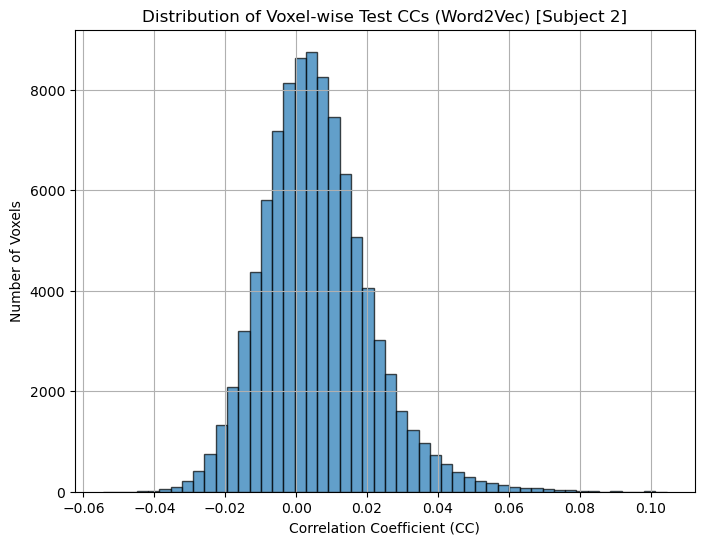

In [115]:
plot_cc_dist('Word2Vec')

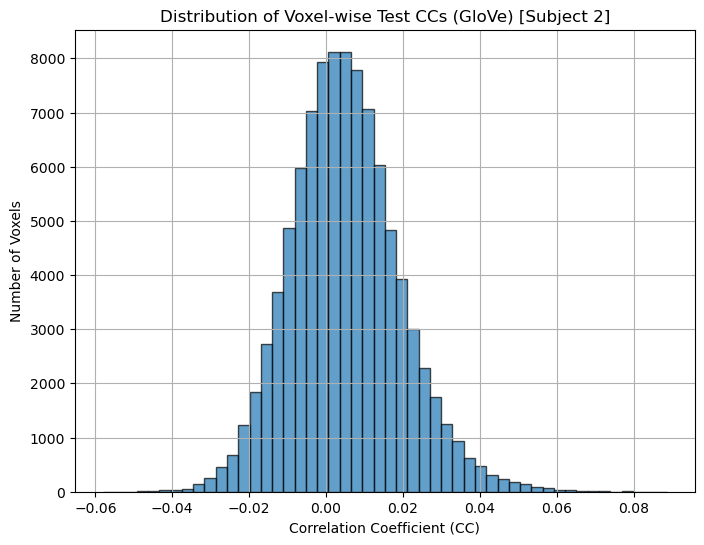

In [116]:
plot_cc_dist('GloVe')

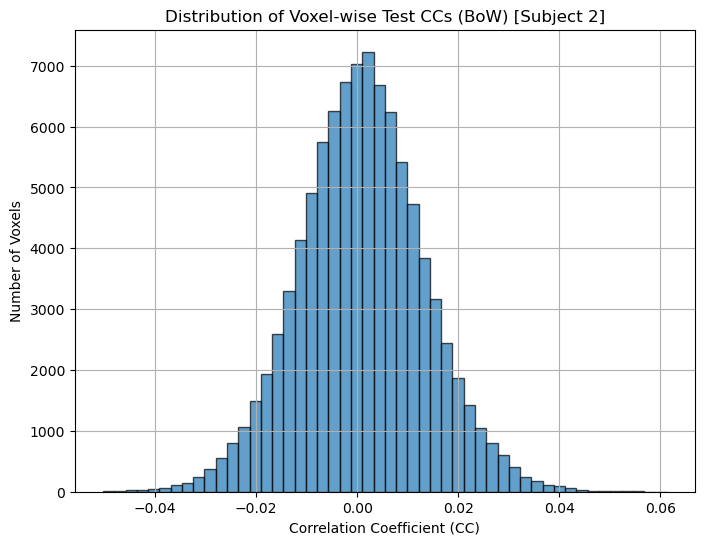

In [117]:
plot_cc_dist('BoW')

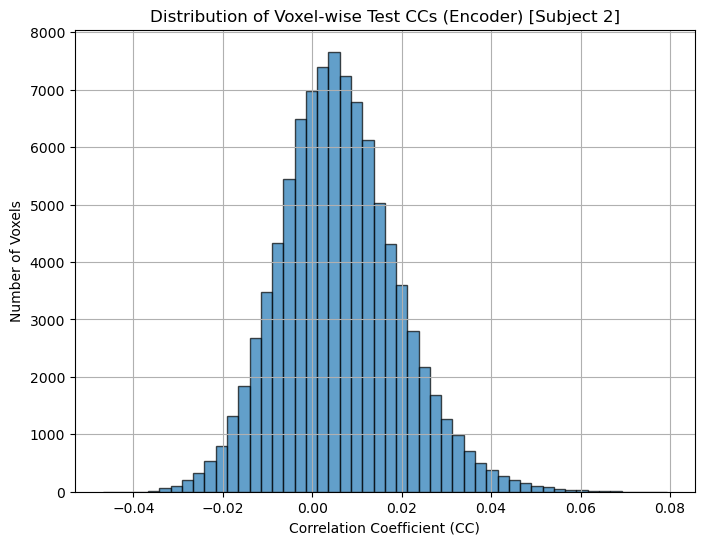

In [55]:
plot_cc_dist('Encoder')